<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - Variational AutoEncoder (VAE) with MNIST
<!-- DESC --> Episode 1 : Model construction and Training

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

<br>**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : VAE1
Run time             : Thursday 7 January 2021, 01:37:48
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/MNIST.001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/MNIST.001/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf


## Step 2 - Parameters
Uncomment the right lines according what you want

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

In [3]:
# ---- Override parameters (batch mode) - Just forget this line
#
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

## Step 3 - Prepare data
### 3.1 - Get it

In [11]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)

Train shape after rescale :  (7000, 28, 28, 1)


### 3.2 - Have a look

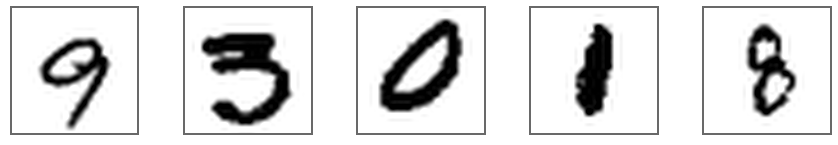

In [12]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [13]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [14]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [16]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [17]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [18]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10
110/110 [==============================] - 6s 51ms/step - loss: 0.3385 - r_loss: 0.3397 - kl_loss: 0.1430
Epoch 2/10
110/110 [==============================] - 5s 48ms/step - loss: 0.2430 - r_loss: 0.2371 - kl_loss: 1.2102
Epoch 3/10
110/110 [==============================] - 5s 49ms/step - loss: 0.2288 - r_loss: 0.2204 - kl_loss: 1.6243
Epoch 4/10
110/110 [==============================] - 5s 48ms/step - loss: 0.2229 - r_loss: 0.2136 - kl_loss: 1.7648
Epoch 5/10
110/110 [==============================] - 6s 56ms/step - loss: 0.2204 - r_loss: 0.2106 - kl_loss: 1.8391
Epoch 6/10
110/110 [==============================] - 6s 58ms/step - loss: 0.2176 - r_loss: 0.2074 - kl_loss: 1.8961
Epoch 7/10
110/110 [==============================] - 6s 54ms/step - loss: 0.2165 - r_loss: 0.2060 - kl_loss: 1.9570
Epoch 8/10
110/110 [==============================] - 7s 59ms/step - loss: 0.2151 - r_loss: 0.2043 - kl_loss: 2.0062
Epoch 9/10
110/110 [==============================] - 6s 57ms/st

## Step 6 - About our training session
### 6.1 - History

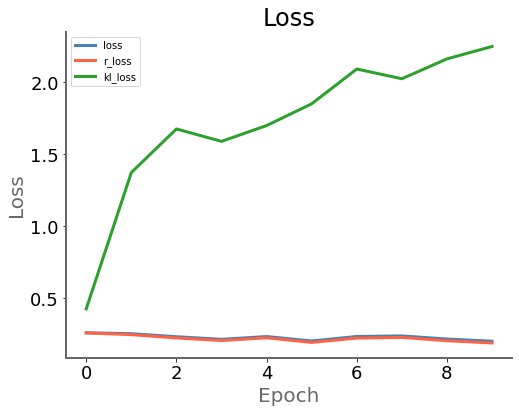

In [19]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

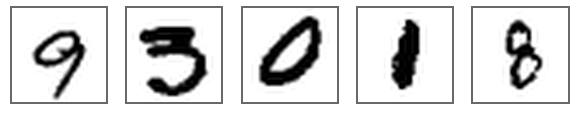

<br>**Encoded/decoded images**

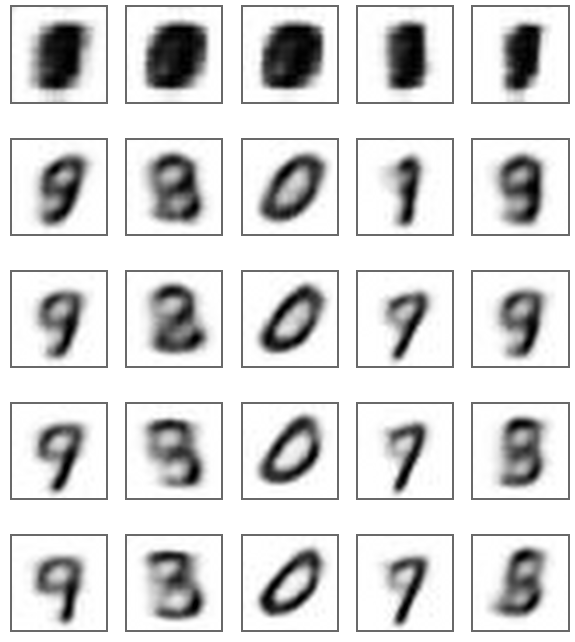

<br>**Original images :**

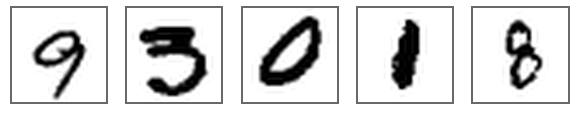

In [20]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 Generation (latent -> decoder)

<br>**Generated images from latent space**

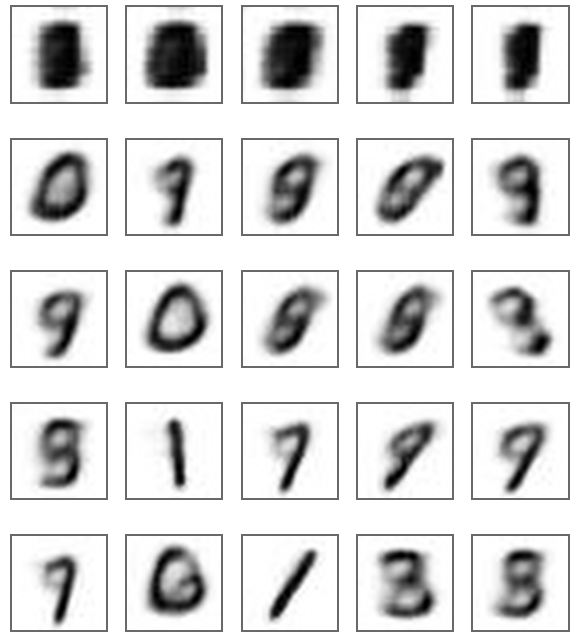

In [21]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [ ]:
pwk.end()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>